Валерія Дружиніна

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate

## Идентификация мошенников среди покупателей в онлайн-магазине

#### Customers_final_ex.csv — данные о покупателях
Описание:
* Customer_id — уникальный идентификатор учетной записи клиента
* age — возраст клиентского счета в месяцах (может быть float)
* num_s — количество посылок, отправленных на адрес, по которому покупатель не проживает в течение последнего месяца
* num_dev — количество различных физических устройств (смартфонов, планшетов, ПК), связанных на данный момент с учетной записью
* gender — мужчина, женщина, другое или нет информации
* Preferred color — предпочтительный цвет заказчика

#### Transactional_info_new.csv — данные о покупках этих покупателей в последнем месяце
Описание:
* transaction_id — уникальный идентификатор покупки
* Dist — расстояние между адресом доставки и домашним адресом в км
* payment_t — тип платежа: 0 — безопасный (кредитные карты, PayPal и т. д.) 1— небезопасный (счет, рассрочка)
* count_dev_is_shop — страна, в которой находится устройство, с которого была совершена транзакция, идентифицируется по IP-адресу, идентична стране магазина (0 — да, 1 — нет)
* basket — стоимость покупки
* product_type — ценность товара в зависимости от типа товара
* Fraudulent_Trans — отметка, считалась ли транзакция мошеннической (истинное значение)
* Customer_id — идентификатор учетной записи клиента, в которой была создана эта транзакция
* Day_of_Week — день недели, когда была создана транзакция (0 - воскресенье, 1 - понедельник и тд)


#### Задание: 
* Проведите анализ полученных данных. Выберите метод анализа из изученных на курсе, обоснуйте свой выбор.
* Проанализируйте, какие факторы важны для находки покупок мошенников, какие нет? 
* Создайте модель, которая будет предсказывать на будущее Fraudulent_Trans. 
* Пришлите файл jupyter notebook с анализом и детальным описанием своей работы: какие методы вы использовали, какие теории и гипотезы вы выдвигали, как вы их проверяли и к каким результатам пришли.

In [3]:
data_customer = pd.read_csv('Customers_final_ex.csv',index_col=0)
data_customer.head()

,age,num_s,num_dev,Preferred_col,Gender
Customer_id,,,,,
customer_448,35.724517,2,3,blue,f
customer_183,17.396979,1,4,brown,f
customer_261,37.054879,3,4,white,m
customer_413,37.090268,0,2,yellow,m
customer_507,47.297710,2,3,yellow,f


In [4]:
data_customer['Preferred_col'].unique()

array(['blue', 'brown', 'white', 'yellow', 'orange', 'black', 'grey',
       'green', 'red', 'pink'], dtype=object)

In [5]:
data_customer['Gender'].unique()

array(['f', 'm', 'd', 'unknown'], dtype=object)

In [6]:
data_customer=pd.get_dummies(data_customer) #преозобрование Preferred_col,Gender в числа в отдельние столбики
data_customer.head()

,age,num_s,num_dev,Preferred_col_black,Preferred_col_blue,Preferred_col_brown,Preferred_col_green,Preferred_col_grey,Preferred_col_orange,Preferred_col_pink,Preferred_col_red,Preferred_col_white,Preferred_col_yellow,Gender_d,Gender_f,Gender_m,Gender_unknown
Customer_id,,,,,,,,,,,,,,,,,
customer_448,35.724517,2,3,0,1,0,0,0,0,0,0,0,0,0,1,0,0
customer_183,17.396979,1,4,0,0,1,0,0,0,0,0,0,0,0,1,0,0
customer_261,37.054879,3,4,0,0,0,0,0,0,0,0,1,0,0,0,1,0
customer_413,37.090268,0,2,0,0,0,0,0,0,0,0,0,1,0,0,1,0
customer_507,47.297710,2,3,0,0,0,0,0,0,0,0,0,1,0,1,0,0


In [7]:
data_transac = pd.read_csv('transactions_final_ex.csv',index_col=0)
data_transac.head()

,Dist,payment_t,count_dev_is_shop,basket,product_type,Customer_id,Day_of_week,Fraudulent_trans
transaction_id,,,,,,,,
transaction_0,105.926953,0.0,0.0,46.390320,0,customer_448,5,0.0
transaction_1,185.256711,1.0,0.0,60.701211,1,customer_183,0,0.0
transaction_2,71.725825,0.0,1.0,79.602869,0,customer_261,2,0.0
transaction_3,15.232666,1.0,0.0,58.815953,2,customer_413,6,0.0
transaction_4,37.660455,1.0,0.0,107.884814,2,customer_507,0,0.0


In [8]:
full_data=data_transac.merge(data_customer, on='Customer_id', how='left')

In [9]:
full_data.info() #є 23 клієнти по яким є транзакції, але немає інформації

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 0 to 999
Data columns (total 25 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Dist                  1000 non-null   float64
 1   payment_t             1000 non-null   float64
 2   count_dev_is_shop     1000 non-null   float64
 3   basket                1000 non-null   float64
 4   product_type          1000 non-null   int64  
 5   Customer_id           1000 non-null   object 
 6   Day_of_week           1000 non-null   int64  
 7   Fraudulent_trans      1000 non-null   float64
 8   age                   977 non-null    float64
 9   num_s                 977 non-null    float64
 10  num_dev               977 non-null    float64
 11  Preferred_col_black   977 non-null    float64
 12  Preferred_col_blue    977 non-null    float64
 13  Preferred_col_brown   977 non-null    float64
 14  Preferred_col_green   977 non-null    float64
 15  Preferred_col_grey    

In [10]:
full_data[full_data.isnull().any(1)] #перевіряємо їх

,Dist,payment_t,count_dev_is_shop,basket,product_type,Customer_id,Day_of_week,Fraudulent_trans,age,num_s,...,Preferred_col_grey,Preferred_col_orange,Preferred_col_pink,Preferred_col_red,Preferred_col_white,Preferred_col_yellow,Gender_d,Gender_f,Gender_m,Gender_unknown
61,57.264814,1.0,1.0,135.965644,2,customer_344,0,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
67,130.511068,1.0,1.0,179.867087,0,customer_131,1,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
101,53.530077,0.0,0.0,185.777788,1,customer_347,3,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
180,103.593813,1.0,0.0,59.244052,0,customer_258,4,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
187,0.000000,0.0,0.0,78.264047,2,customer_352,4,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
270,252.946057,1.0,1.0,266.900696,2,customer_210,3,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
435,0.000000,1.0,0.0,169.710731,0,customer_352,0,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
438,0.000000,0.0,0.0,77.001978,0,customer_352,4,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
448,118.893192,1.0,0.0,98.633436,1,customer_75,6,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
486,86.797662,0.0,0.0,46.888961,0,customer_7,0,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Inner JOIN

In [11]:
full_data=data_transac.merge(data_customer, on='Customer_id', how='inner')

In [12]:
full_data.head()

,Dist,payment_t,count_dev_is_shop,basket,product_type,Customer_id,Day_of_week,Fraudulent_trans,age,num_s,...,Preferred_col_grey,Preferred_col_orange,Preferred_col_pink,Preferred_col_red,Preferred_col_white,Preferred_col_yellow,Gender_d,Gender_f,Gender_m,Gender_unknown
0,105.926953,0.0,0.0,46.390320,0,customer_448,5,0.0,35.724517,2,...,0,0,0,0,0,0,0,1,0,0
1,185.256711,1.0,0.0,60.701211,1,customer_183,0,0.0,17.396979,1,...,0,0,0,0,0,0,0,1,0,0
2,0.000000,1.0,0.0,114.037251,1,customer_183,5,0.0,17.396979,1,...,0,0,0,0,0,0,0,1,0,0
3,71.725825,0.0,1.0,79.602869,0,customer_261,2,0.0,37.054879,3,...,0,0,0,0,1,0,0,0,1,0
4,86.797662,1.0,1.0,155.420436,0,customer_261,6,0.0,37.054879,3,...,0,0,0,0,1,0,0,0,1,0


In [13]:
dupl = full_data[["Customer_id", "Fraudulent_trans"]]
#duplicateRows = dupl[dupl.duplicated(['Customer_id', 'Fraudulent_trans'])] #проверка на дубликаты
duplicateRows = dupl[dupl.duplicated(keep='last')] # вся таблица
duplicateRows

,Customer_id,Fraudulent_trans
1,customer_183,0.0
3,customer_261,0.0
4,customer_261,0.0
6,customer_413,0.0
8,customer_507,0.0
...,...,...
949,customer_68,0.0
951,customer_361,0.0
956,customer_350,0.0
963,customer_112,0.0


In [14]:
NFrau=full_data[(full_data['Fraudulent_trans']==0)]
NFrau.describe()

,Dist,payment_t,count_dev_is_shop,basket,product_type,Day_of_week,Fraudulent_trans,age,num_s,num_dev,...,Preferred_col_grey,Preferred_col_orange,Preferred_col_pink,Preferred_col_red,Preferred_col_white,Preferred_col_yellow,Gender_d,Gender_f,Gender_m,Gender_unknown
count,856.000000,856.000000,856.000000,856.000000,856.000000,856.000000,856.0,856.000000,856.000000,856.000000,...,856.000000,856.000000,856.000000,856.000000,856.000000,856.000000,856.000000,856.000000,856.000000,856.000000
mean,35.111419,0.573598,0.051402,101.557438,1.017523,2.646028,0.0,35.259406,1.613318,3.627336,...,0.108645,0.112150,0.088785,0.099299,0.096963,0.119159,0.088785,0.489486,0.323598,0.098131
std,64.908882,0.494843,0.220945,89.876044,0.815592,2.359935,0.0,11.365614,1.612455,1.343000,...,0.311375,0.315735,0.284600,0.299238,0.296080,0.324165,0.284600,0.500182,0.468122,0.297665
min,0.000000,0.000000,0.000000,24.022646,0.000000,0.000000,0.0,0.464860,0.000000,2.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,50.818905,0.000000,0.000000,0.0,29.850369,0.000000,3.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,1.000000,0.000000,78.102659,1.000000,2.000000,0.0,38.300640,1.000000,4.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,48.643786,1.000000,0.000000,122.557635,2.000000,5.000000,0.0,44.644014,3.000000,4.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000
max,507.146572,1.000000,1.000000,1406.004465,2.000000,6.000000,0.0,47.914771,11.000000,10.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [15]:
Fraud=full_data[(full_data['Fraudulent_trans']==1)]
Fraud.describe()

,Dist,payment_t,count_dev_is_shop,basket,product_type,Day_of_week,Fraudulent_trans,age,num_s,num_dev,...,Preferred_col_grey,Preferred_col_orange,Preferred_col_pink,Preferred_col_red,Preferred_col_white,Preferred_col_yellow,Gender_d,Gender_f,Gender_m,Gender_unknown
count,121.000000,121.000000,121.000000,121.000000,121.000000,121.000000,121.0,121.000000,121.000000,121.000000,...,121.000000,121.00000,121.000000,121.000000,121.00000,121.000000,121.000000,121.000000,121.000000,121.000000
mean,111.618110,0.776860,0.578512,157.964043,0.958678,2.297521,1.0,33.173543,2.727273,4.446281,...,0.099174,0.07438,0.107438,0.090909,0.07438,0.132231,0.057851,0.528926,0.280992,0.132231
std,120.112744,0.418083,0.495851,112.530299,0.768079,2.238469,0.0,13.372837,1.746425,1.466006,...,0.300138,0.26348,0.310957,0.288675,0.26348,0.340151,0.234433,0.501238,0.451352,0.340151
min,0.000000,0.000000,0.000000,24.820839,0.000000,0.000000,1.0,0.032075,0.000000,2.000000,...,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,77.026904,0.000000,0.000000,1.0,25.040922,1.000000,4.000000,...,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,87.447677,1.000000,1.000000,153.512484,1.000000,2.000000,1.0,37.699140,3.000000,5.000000,...,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,1.000000,0.000000,0.000000
75%,156.107310,1.000000,1.000000,189.967475,2.000000,4.000000,1.0,43.968090,4.000000,5.000000,...,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,1.000000,1.000000,0.000000
max,543.151902,1.000000,1.000000,808.495981,2.000000,6.000000,1.0,47.914771,7.000000,8.000000,...,1.000000,1.00000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000


In [16]:
NFrau['Dist'].count()

856

In [17]:
#застосуємо Вальд тести для зміних
s=np.sqrt(NFrau['Dist'].var()/NFrau['Dist'].count()+Fraud['Dist'].var()/Fraud['Dist'].count())
d=NFrau['Dist'].mean()-Fraud['Dist'].mean()
W=d/np.sqrt(NFrau['Dist'].var()/NFrau['Dist'].count()+Fraud['Dist'].var()/Fraud['Dist'].count())
p=2*stats.norm.cdf(-np.abs(W))
p #різниця між сред у змінній є

6.591446774254829e-12

In [18]:
#застосуємо Вальд тести для зміних
s=np.sqrt(NFrau['payment_t'].var()/NFrau['payment_t'].count()+Fraud['payment_t'].var()/Fraud['payment_t'].count())
d=NFrau['payment_t'].mean()-Fraud['payment_t'].mean()
W=d/np.sqrt(NFrau['payment_t'].var()/NFrau['payment_t'].count()+Fraud['payment_t'].var()/Fraud['payment_t'].count())
p=2*stats.norm.cdf(-np.abs(W))
p #різниця між сред у змінній є

1.029137237559469e-06

In [19]:
#застосуємо Вальд тести для зміних
s=np.sqrt(NFrau['count_dev_is_shop'].var()/NFrau['count_dev_is_shop'].count()+Fraud['count_dev_is_shop'].var()/Fraud['count_dev_is_shop'].count())
d=NFrau['count_dev_is_shop'].mean()-Fraud['count_dev_is_shop'].mean()
W=d/np.sqrt(NFrau['count_dev_is_shop'].var()/NFrau['count_dev_is_shop'].count()+Fraud['count_dev_is_shop'].var()/Fraud['count_dev_is_shop'].count())
p=2*stats.norm.cdf(-np.abs(W))
p #різниця між сред у змінній є


9.020895415742054e-31

In [20]:
#застосуємо Вальд тести для зміних
s=np.sqrt(NFrau['basket'].var()/NFrau['basket'].count()+Fraud['basket'].var()/Fraud['basket'].count())
d=NFrau['basket'].mean()-Fraud['basket'].mean()
W=d/np.sqrt(NFrau['basket'].var()/NFrau['basket'].count()+Fraud['basket'].var()/Fraud['basket'].count())
p=2*stats.norm.cdf(-np.abs(W))
p #різниця між сред у змінній є

1.2856642929454343e-07

In [21]:
#застосуємо Вальд тести для зміних
s=np.sqrt(NFrau['product_type'].var()/NFrau['product_type'].count()+Fraud['product_type'].var()/Fraud['product_type'].count())
d=NFrau['product_type'].mean()-Fraud['product_type'].mean()
W=d/np.sqrt(NFrau['product_type'].var()/NFrau['product_type'].count()+Fraud['product_type'].var()/Fraud['product_type'].count())
p=2*stats.norm.cdf(-np.abs(W))
p #приймаємо Гіпотезу НО

0.43381125696425693

In [22]:
#застосуємо Вальд тести для зміних
s=np.sqrt(NFrau['Day_of_week'].var()/NFrau['Day_of_week'].count()+Fraud['Day_of_week'].var()/Fraud['Day_of_week'].count())
d=NFrau['Day_of_week'].mean()-Fraud['Day_of_week'].mean()
W=d/np.sqrt(NFrau['Day_of_week'].var()/NFrau['Day_of_week'].count()+Fraud['Day_of_week'].var()/Fraud['Day_of_week'].count())
p=2*stats.norm.cdf(-np.abs(W))
p #приймаємо Гіпотезу НО

0.11136593870222139

In [23]:
#застосуємо Вальд тести для зміних
s=np.sqrt(NFrau['age'].var()/NFrau['age'].count()+Fraud['age'].var()/Fraud['age'].count())
d=NFrau['age'].mean()-Fraud['age'].mean()
W=d/np.sqrt(NFrau['age'].var()/NFrau['age'].count()+Fraud['age'].var()/Fraud['age'].count())
p=2*stats.norm.cdf(-np.abs(W))
p #приймаємо Гіпотезу НО

0.10218678068334094

In [24]:
#застосуємо Вальд тести для зміних
s=np.sqrt(NFrau['num_s'].var()/NFrau['num_s'].count()+Fraud['num_s'].var()/Fraud['num_s'].count())
d=NFrau['num_s'].mean()-Fraud['num_s'].mean()
W=d/np.sqrt(NFrau['num_s'].var()/NFrau['num_s'].count()+Fraud['num_s'].var()/Fraud['num_s'].count())
p=2*stats.norm.cdf(-np.abs(W))
p #різниця між сред у змінній є

3.3949295392996446e-11

In [25]:
#застосуємо Вальд тести для зміних
s=np.sqrt(NFrau['num_dev'].var()/NFrau['num_dev'].count()+Fraud['num_dev'].var()/Fraud['num_dev'].count())
d=NFrau['num_dev'].mean()-Fraud['num_dev'].mean()
W=d/np.sqrt(NFrau['num_dev'].var()/NFrau['num_dev'].count()+Fraud['num_dev'].var()/Fraud['num_dev'].count())
p=2*stats.norm.cdf(-np.abs(W))
p #різниця між сред у змінній є

6.251183626143432e-09

In [26]:
#застосуємо Вальд тести для зміних
s=np.sqrt(NFrau['Preferred_col_black'].var()/NFrau['Preferred_col_black'].count()+Fraud['Preferred_col_black'].var()/Fraud['Preferred_col_black'].count())
d=NFrau['Preferred_col_black'].mean()-Fraud['Preferred_col_black'].mean()
W=d/np.sqrt(NFrau['Preferred_col_black'].var()/NFrau['Preferred_col_black'].count()+Fraud['Preferred_col_black'].var()/Fraud['Preferred_col_black'].count())
p=2*stats.norm.cdf(-np.abs(W))
p #приймаємо Гіпотезу НО

0.4846828521829546

In [27]:
#застосуємо Вальд тести для зміних
s=np.sqrt(NFrau['Preferred_col_blue'].var()/NFrau['Preferred_col_blue'].count()+Fraud['Preferred_col_blue'].var()/Fraud['Preferred_col_blue'].count())
d=NFrau['Preferred_col_blue'].mean()-Fraud['Preferred_col_blue'].mean()
W=d/np.sqrt(NFrau['Preferred_col_blue'].var()/NFrau['Preferred_col_blue'].count()+Fraud['Preferred_col_blue'].var()/Fraud['Preferred_col_blue'].count())
p=2*stats.norm.cdf(-np.abs(W))
p #приймаємо Гіпотезу НО

0.5195838953718912

In [28]:
#застосуємо Вальд тести для зміних
s=np.sqrt(NFrau['Preferred_col_green'].var()/NFrau['Preferred_col_green'].count()+Fraud['Preferred_col_green'].var()/Fraud['Preferred_col_green'].count())
d=NFrau['Preferred_col_green'].mean()-Fraud['Preferred_col_green'].mean()
W=d/np.sqrt(NFrau['Preferred_col_green'].var()/NFrau['Preferred_col_green'].count()+Fraud['Preferred_col_green'].var()/Fraud['Preferred_col_green'].count())
p=2*stats.norm.cdf(-np.abs(W))
p #приймаємо Гіпотезу НО

0.3465250393188156

In [29]:
#застосуємо Вальд тести для зміних
s=np.sqrt(NFrau['Preferred_col_green'].var()/NFrau['Preferred_col_green'].count()+Fraud['Preferred_col_green'].var()/Fraud['Preferred_col_green'].count())
d=NFrau['Preferred_col_green'].mean()-Fraud['Preferred_col_green'].mean()
W=d/np.sqrt(NFrau['Preferred_col_green'].var()/NFrau['Preferred_col_green'].count()+Fraud['Preferred_col_green'].var()/Fraud['Preferred_col_green'].count())
p=2*stats.norm.cdf(-np.abs(W))
p #приймаємо Гіпотезу НО

0.3465250393188156

In [30]:
#застосуємо Вальд тести для зміних
s=np.sqrt(NFrau['Preferred_col_grey'].var()/NFrau['Preferred_col_grey'].count()+Fraud['Preferred_col_grey'].var()/Fraud['Preferred_col_grey'].count())
d=NFrau['Preferred_col_grey'].mean()-Fraud['Preferred_col_grey'].mean()
W=d/np.sqrt(NFrau['Preferred_col_grey'].var()/NFrau['Preferred_col_grey'].count()+Fraud['Preferred_col_grey'].var()/Fraud['Preferred_col_grey'].count())
p=2*stats.norm.cdf(-np.abs(W))
p #приймаємо Гіпотезу НО

0.7463981360067854

In [31]:
#застосуємо Вальд тести для зміних
s=np.sqrt(NFrau['Preferred_col_orange'].var()/NFrau['Preferred_col_orange'].count()+Fraud['Preferred_col_orange'].var()/Fraud['Preferred_col_orange'].count())
d=NFrau['Preferred_col_orange'].mean()-Fraud['Preferred_col_orange'].mean()
W=d/np.sqrt(NFrau['Preferred_col_orange'].var()/NFrau['Preferred_col_orange'].count()+Fraud['Preferred_col_orange'].var()/Fraud['Preferred_col_orange'].count())
p=2*stats.norm.cdf(-np.abs(W))
p #приймаємо Гіпотезу НО

0.1505312494090593

In [32]:
#застосуємо Вальд тести для зміних
s=np.sqrt(NFrau['Preferred_col_pink'].var()/NFrau['Preferred_col_pink'].count()+Fraud['Preferred_col_pink'].var()/Fraud['Preferred_col_pink'].count())
d=NFrau['Preferred_col_pink'].mean()-Fraud['Preferred_col_pink'].mean()
W=d/np.sqrt(NFrau['Preferred_col_pink'].var()/NFrau['Preferred_col_pink'].count()+Fraud['Preferred_col_pink'].var()/Fraud['Preferred_col_pink'].count())
p=2*stats.norm.cdf(-np.abs(W))
p  #приймаємо Гіпотезу НО

0.5326693004526998

In [33]:
#застосуємо Вальд тести для зміних
s=np.sqrt(NFrau['Preferred_col_red'].var()/NFrau['Preferred_col_red'].count()+Fraud['Preferred_col_red'].var()/Fraud['Preferred_col_red'].count())
d=NFrau['Preferred_col_red'].mean()-Fraud['Preferred_col_red'].mean()
W=d/np.sqrt(NFrau['Preferred_col_red'].var()/NFrau['Preferred_col_red'].count()+Fraud['Preferred_col_red'].var()/Fraud['Preferred_col_red'].count())
p=2*stats.norm.cdf(-np.abs(W))
p  #приймаємо Гіпотезу НО

0.765796170734756

In [34]:
#застосуємо Вальд тести для зміних
s=np.sqrt(NFrau['Preferred_col_white'].var()/NFrau['Preferred_col_white'].count()+Fraud['Preferred_col_white'].var()/Fraud['Preferred_col_white'].count())
d=NFrau['Preferred_col_white'].mean()-Fraud['Preferred_col_white'].mean()
W=d/np.sqrt(NFrau['Preferred_col_white'].var()/NFrau['Preferred_col_white'].count()+Fraud['Preferred_col_white'].var()/Fraud['Preferred_col_white'].count())
p=2*stats.norm.cdf(-np.abs(W))
p  #приймаємо Гіпотезу НО

0.3851399189040754

In [35]:
#застосуємо Вальд тести для зміних
s=np.sqrt(NFrau['Preferred_col_yellow'].var()/NFrau['Preferred_col_yellow'].count()+Fraud['Preferred_col_yellow'].var()/Fraud['Preferred_col_yellow'].count())
d=NFrau['Preferred_col_yellow'].mean()-Fraud['Preferred_col_yellow'].mean()
W=d/np.sqrt(NFrau['Preferred_col_yellow'].var()/NFrau['Preferred_col_yellow'].count()+Fraud['Preferred_col_yellow'].var()/Fraud['Preferred_col_yellow'].count())
p=2*stats.norm.cdf(-np.abs(W))
p  #приймаємо Гіпотезу НО

0.6906504932331164

In [36]:
#застосуємо Вальд тести для зміних
s=np.sqrt(NFrau['Gender_d'].var()/NFrau['Gender_d'].count()+Fraud['Gender_d'].var()/Fraud['Gender_d'].count())
d=NFrau['Gender_d'].mean()-Fraud['Gender_d'].mean()
W=d/np.sqrt(NFrau['Gender_d'].var()/NFrau['Gender_d'].count()+Fraud['Gender_d'].var()/Fraud['Gender_d'].count())
p=2*stats.norm.cdf(-np.abs(W))
p  #приймаємо Гіпотезу НО

0.1866910239290177

In [37]:
#застосуємо Вальд тести для зміних
s=np.sqrt(NFrau['Gender_f'].var()/NFrau['Gender_f'].count()+Fraud['Gender_f'].var()/Fraud['Gender_f'].count())
d=NFrau['Gender_f'].mean()-Fraud['Gender_f'].mean()
W=d/np.sqrt(NFrau['Gender_f'].var()/NFrau['Gender_f'].count()+Fraud['Gender_f'].var()/Fraud['Gender_f'].count())
p=2*stats.norm.cdf(-np.abs(W))
p  #приймаємо Гіпотезу НО

0.4177264560239252

In [38]:
#застосуємо Вальд тести для зміних
s=np.sqrt(NFrau['Gender_m'].var()/NFrau['Gender_m'].count()+Fraud['Gender_m'].var()/Fraud['Gender_m'].count())
d=NFrau['Gender_m'].mean()-Fraud['Gender_m'].mean()
W=d/np.sqrt(NFrau['Gender_m'].var()/NFrau['Gender_m'].count()+Fraud['Gender_m'].var()/Fraud['Gender_m'].count())
p=2*stats.norm.cdf(-np.abs(W))
p  #приймаємо Гіпотезу НО

0.3333339177650855

In [39]:
#застосуємо Вальд тести для зміних
s=np.sqrt(NFrau['Gender_unknown'].var()/NFrau['Gender_unknown'].count()+Fraud['Gender_unknown'].var()/Fraud['Gender_unknown'].count())
d=NFrau['Gender_unknown'].mean()-Fraud['Gender_unknown'].mean()
W=d/np.sqrt(NFrau['Gender_unknown'].var()/NFrau['Gender_unknown'].count()+Fraud['Gender_unknown'].var()/Fraud['Gender_unknown'].count())
p=2*stats.norm.cdf(-np.abs(W))
p  #приймаємо Гіпотезу НО

0.2948577791907312

In [40]:
NFrau.columns

Index(['Dist', 'payment_t', 'count_dev_is_shop', 'basket', 'product_type',
       'Customer_id', 'Day_of_week', 'Fraudulent_trans', 'age', 'num_s',
       'num_dev', 'Preferred_col_black', 'Preferred_col_blue',
       'Preferred_col_brown', 'Preferred_col_green', 'Preferred_col_grey',
       'Preferred_col_orange', 'Preferred_col_pink', 'Preferred_col_red',
       'Preferred_col_white', 'Preferred_col_yellow', 'Gender_d', 'Gender_f',
       'Gender_m', 'Gender_unknown'],
      dtype='object')

In [44]:
test_2 = full_data[["Dist", "payment_t","count_dev_is_shop","num_s","num_dev","basket","Fraudulent_trans"]] 
#вибрали тільки тих у кого відхили теорію Н0

In [45]:
test_2.corr()

,Dist,payment_t,count_dev_is_shop,num_s,num_dev,basket,Fraudulent_trans
Dist,1.000000,0.119277,0.370733,0.240812,0.213032,0.237649,0.322832
payment_t,0.119277,1.000000,0.264995,0.083220,0.061376,0.109096,0.136604
count_dev_is_shop,0.370733,0.264995,1.000000,0.356040,0.283182,0.259125,0.540846
num_s,0.240812,0.083220,0.356040,1.000000,0.443703,0.187177,0.219898
num_dev,0.213032,0.061376,0.283182,0.443703,1.000000,0.203568,0.194933
basket,0.237649,0.109096,0.259125,0.187177,0.203568,1.000000,0.196191
Fraudulent_trans,0.322832,0.136604,0.540846,0.219898,0.194933,0.196191,1.000000


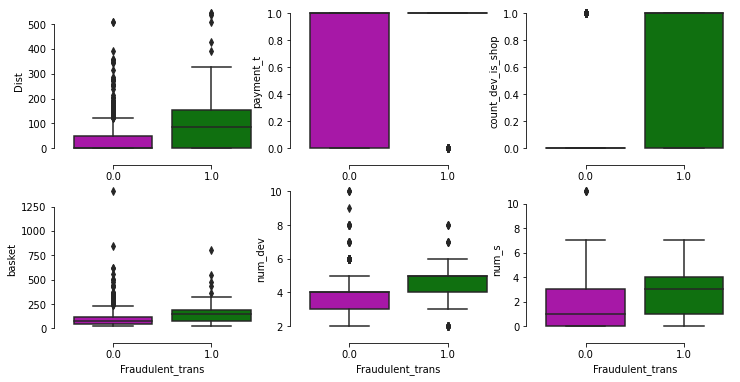

In [46]:
fig, ax = plt.subplots(2,3,figsize=(12,6))
sns.boxplot(ax=ax[0,0],x="Fraudulent_trans", y="Dist",
            palette=["m", "g"],
            data=full_data)
sns.boxplot(ax=ax[0,1],x="Fraudulent_trans", y="payment_t",
            palette=["m", "g"],
            data=full_data)
sns.boxplot(ax=ax[0,2],x="Fraudulent_trans", y="count_dev_is_shop",
            palette=["m", "g"],
            data=full_data)
sns.boxplot(ax=ax[1,0],x="Fraudulent_trans", y="basket",
            palette=["m", "g"],
            data=full_data)
sns.boxplot(ax=ax[1,1],x="Fraudulent_trans", y="num_dev",
            palette=["m", "g"],
            data=full_data)
sns.boxplot(ax=ax[1,2],x="Fraudulent_trans", y="num_s",
            palette=["m", "g"],
            data=full_data)
sns.despine(offset=10, trim=True)

In [54]:
X = full_data[['Dist','payment_t','count_dev_is_shop','num_s','num_dev']]#,'basket'
y = full_data['Fraudulent_trans']   

In [55]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=42)

In [56]:
clf = LogisticRegression(random_state=0).fit(X, y)
p = clf.predict_proba(X)# вероятности
clas = clf.predict(X) # классы 

<AxesSubplot:xlabel='Fraudulent_trans', ylabel='Count'>

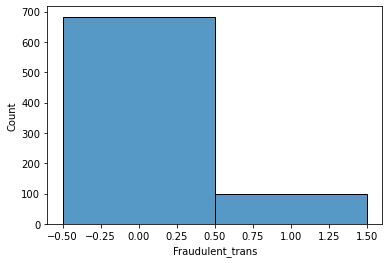

In [57]:
sns.histplot(y_train,discrete=True)

In [58]:
len(y_train[y_train==1])/len(y_train)

0.12548015364916773

In [59]:
new_model= LogisticRegression(random_state=0).fit(X_train, y_train)
new_model

LogisticRegression(random_state=0)

In [60]:
results_train = new_model.predict(X_train)

In [61]:
results_test = new_model.predict(X_test)

In [62]:
accuracy_score(y_train, results_train)

0.9231754161331626

In [63]:
precision_score(y_train,results_train)

0.7317073170731707

In [64]:
recall_score(y_train,results_train)

0.6122448979591837

In [65]:
#TEST
accuracy_score(y_test,results_test)

0.8928571428571429

In [66]:
precision_score(y_test,results_test)

0.5625

In [67]:
recall_score(y_test,results_test)

0.391304347826087

In [68]:
#Перекресная проверка
log_model = LogisticRegression()
res = cross_validate(log_model,X,y,cv=10,scoring=['recall','precision'])
res['test_recall'].mean()


0.5532051282051282

In [69]:
res['test_precision'].mean()

0.7439646464646464

In [70]:
accuracy_score(y_test,results_test)

0.8928571428571429

In [71]:
recall_score(y_train,results_train)

0.6122448979591837